# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [2]:
# Dependencies and setup:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
%matplotlib inline

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

616

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [5]:
# Save config information:
url='http://api.openweathermap.org/data/2.5/weather?'
units='imperial'

# Build partial query URL:
query_url=f'{url}appid={weather_api_key}&units={units}&q='

In [6]:
# Set up lists to hold response info:
name=[]         # list for city name
cloud=[]        # list for cloudines
ctry=[]         # list for country
date=[]         # list for date
humi=[]         # list for humidity
lat=[]          # list for latitude
lng=[]          # list for longitude
maxtemp=[]      # list for max temperature
wind=[]         # list for wind speed

# Loop through the list of cities and perform a request for data on each and add data to corresponding lists:

count=1 # Set counter to start value 1 for printouts of the current set count.

print('Beginning Data Retrieval')     
print('-----------------------------')
for city in cities:
        response=requests.get(query_url + city).json()
        
        print('Processing Record ' + str(count) + ' of ' + str(len(cities)) + ' | ' + city)
        
        try:                                                # Ignore errors in response.
            name.append(response['name'])
            cloud.append(response['clouds']['all'])
            ctry.append(response['sys']['country'])
            date.append(response['dt'])
            humi.append(response['main']['humidity'])             
            lat.append(response['coord']['lat'])
            lng.append(response['coord']['lon'])             
            maxtemp.append(response['main']['temp_max'])
            wind.append(response['wind']['speed'])     
        except KeyError:
            
            print(city + ' city not found. Skipping...') # In case one of the responses comes back with error "KeyError"
                                                            # which could be the city or one of the data points missing.    
        count=count+1

Beginning Data Retrieval
-----------------------------
Processing Record 1 of 616 | pevek
Processing Record 2 of 616 | bhiwandi
Processing Record 3 of 616 | georgetown
Processing Record 4 of 616 | barrow
Processing Record 5 of 616 | katherine
Processing Record 6 of 616 | boa vista
Processing Record 7 of 616 | bluff
Processing Record 8 of 616 | vardo
Processing Record 9 of 616 | vao
Processing Record 10 of 616 | westport
Processing Record 11 of 616 | tasiilaq
Processing Record 12 of 616 | busselton
Processing Record 13 of 616 | cherskiy
Processing Record 14 of 616 | ponta do sol
Processing Record 15 of 616 | dudinka
Processing Record 16 of 616 | natal
Processing Record 17 of 616 | hermanus
Processing Record 18 of 616 | ust-nera
Processing Record 19 of 616 | punta arenas
Processing Record 20 of 616 | atuona
Processing Record 21 of 616 | ushuaia
Processing Record 22 of 616 | taolanaro
taolanaro city not found. Skipping...
Processing Record 23 of 616 | east london
Processing Record 24 of 6

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [8]:
# Create a data frame from api call list:
weather_dict = {
    'City': name,
    'Country': ctry,
    'Date': date,
    'Lat': lat,
    'Lng': lng,
    'Cloudiness (%)': cloud,
    'Humidity (%)': humi,
    'Max Temp (F)': maxtemp,
    'Wind Speed (mph)': wind
}

weather_data=pd.DataFrame(weather_dict)

# Test/clean data:
weather_data.isnull().sum()
weather_data.dropna() 
weather_data.count()

City                568
Country             568
Date                568
Lat                 568
Lng                 568
Cloudiness (%)      568
Humidity (%)        568
Max Temp (F)        568
Wind Speed (mph)    568
dtype: int64

In [12]:
# Export the weather_data into .csv file path specified with output_data_file:
weather_data.to_csv('../output_data_file', index=False)

# Display the data frame:
weather_data.head()

,City,Country,Date,Lat,Lng,Cloudiness (%),Humidity (%),Max Temp (F),Wind Speed (mph)
0,Pevek,RU,1654732134,69.7008,170.3133,82,69,41.99,3.24
1,Bhiwandi,IN,1654732134,19.3000,73.0667,98,71,85.86,4.41
2,George Town,MY,1654732135,5.4112,100.3354,20,93,80.53,3.44
3,Barrow,US,1654732135,71.2906,-156.7887,100,80,28.42,4.61
4,Katherine,AU,1654732135,-14.4667,132.2667,100,28,70.12,14.97


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [15]:
#check if there are any cities with >100% humidity
test_stats = weather_data["Humidity (%)"].describe(include = "all")
print("By inspection, the maximum humidity value is 100%, so there are no values greater than 100% in our data!")
test_stats


By inspection, the maximum humidity value is 100%, so there are no values greater than 100% in our data!


count    568.000000
mean      69.390845
std       21.349582
min        1.000000
25%       57.000000
50%       75.000000
75%       86.000000
max      100.000000
Name: Humidity (%), dtype: float64

In [17]:
#  Get the indices of cities that have humidity over 100%.


Int64Index([], dtype='int64')

In [19]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,butaritari,3.07,172.79,83.32,74,84,10.42,KI,1593605283
1,yerbogachen,61.28,108.01,79.52,58,20,7.70,RU,1593605121
2,cape town,-33.93,18.42,73.00,77,27,4.70,ZA,1593605039
3,touba,8.28,-7.68,79.97,75,82,3.58,CI,1593605284
4,jamestown,42.10,-79.24,64.00,88,1,6.93,US,1593605284


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

In [17]:
# Load csv file so querry does not need to run every time for the below plots:
file_to_load='../output_data/cities.csv' # csv file created from the extracted data above. 

# Read csv file and store it into data frame:
weather_data=pd.read_csv(file_to_load)

weather_data.count()
weather_data.isnull().sum()
weather_data.dropna()
weather_data.head()

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,0,ostrovnoy,2,RU,1558378754,72,68.05,39.51,37.50,7.16
1,1,mahebourg,75,MU,1558378503,74,-20.41,57.70,78.80,11.41
2,2,qaanaaq,25,GL,1558378755,73,77.48,-69.36,22.20,2.37
3,3,zhuhai,0,CN,1558378755,39,40.71,112.04,44.60,4.47
4,4,cape town,20,ZA,1558378755,76,-33.93,18.42,55.99,8.05


/var/folders/n7/sntrh25x5b158s65t0zfwdv40000gn/T/ipykernel_23963/3613690211.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.title('City Latitude vs. Max Temperature ' + '(' + str(pd.datetime.now().date()) + ')', fontsize=20)


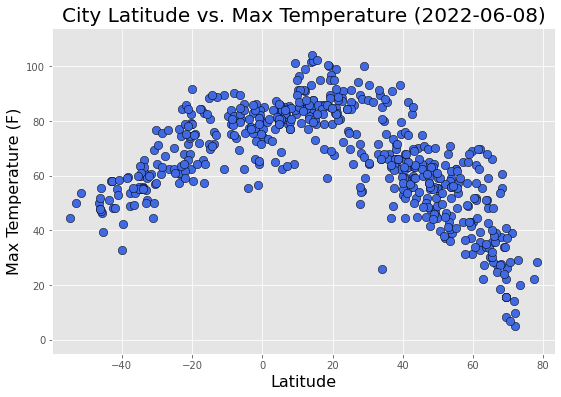

In [21]:
# Build a scatter plot for all cities vs max. temp.:
plt.figure(figsize=(9,6))
plt.scatter(weather_data['Lat'], weather_data['Max Temp'], marker='o', edgecolors='black', color='royalblue',  s=[70])

# Incorporate the other graph properties:
plt.title('City Latitude vs. Max Temperature ' + '(' + str(pd.datetime.now().date()) + ')', fontsize=20)
plt.ylabel('Max Temperature (F)', fontsize=16, color='black')
plt.xlabel('Latitude', fontsize=16, color='black')

# Set the limits of the y axis:
plt.ylim(min(weather_data['Max Temp'])-10, max(weather_data['Max Temp'])+10)

# Set the limits of the x axis:
plt.xlim(min(weather_data['Lat'])-5, max(weather_data['Lat'])+5)

# Save the figure:
plt.savefig('../output_data/City Latitude vs. MaxTemp.png')

# Show plot:
plt.show()

## Latitude vs. Humidity Plot

/var/folders/n7/sntrh25x5b158s65t0zfwdv40000gn/T/ipykernel_23963/3803285127.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.title('City Latitude vs. Humidity ' + '(' + str(pd.datetime.now().date()) + ')', fontsize=20)


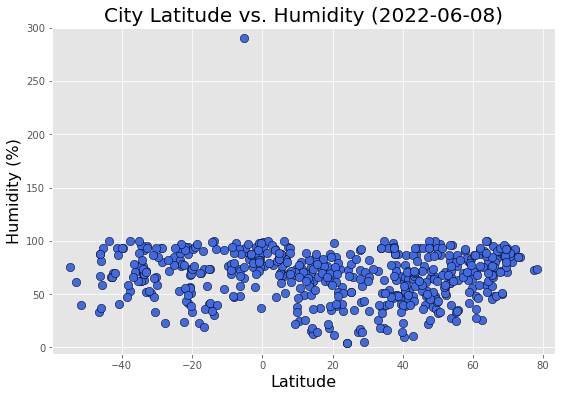

In [24]:
# Build a scatter plot for all cities vs humidity level:
plt.figure(figsize=(9,6))
plt.scatter(weather_data['Lat'], weather_data['Humidity'], marker='o', edgecolors='black', color='royalblue',  s=[70])

# Incorporate the other graph properties:
plt.title('City Latitude vs. Humidity ' + '(' + str(pd.datetime.now().date()) + ')', fontsize=20)
plt.ylabel('Humidity (%)', fontsize=16, color='black')
plt.xlabel('Latitude', fontsize=16, color='black')

# Set the limits of the y axis:
plt.ylim(min(weather_data['Humidity'])-10, max(weather_data['Humidity'])+10)

# Set the limits of the x axis:
plt.xlim(min(weather_data['Lat'])-5, max(weather_data['Lat'])+5)

# Save the figure:
plt.savefig('../output_data/City Latitude vs. Humidity.png')

# Show plot:
plt.show()

## Latitude vs. Cloudiness Plot

/var/folders/n7/sntrh25x5b158s65t0zfwdv40000gn/T/ipykernel_23963/3590225126.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.title('City Latitude vs. Cloudiness ' + '(' + str(pd.datetime.now().date()) + ')', fontsize=20)


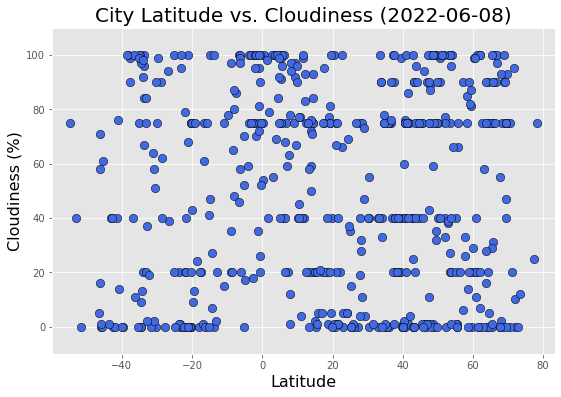

In [26]:
# Build a scatter plot for all cities vs cloudiness level:
plt.figure(figsize=(9,6))
plt.scatter(weather_data['Lat'], weather_data['Cloudiness'], marker='o', edgecolors='black', color='royalblue',  s=[70])

# Incorporate the other graph properties:
plt.title('City Latitude vs. Cloudiness ' + '(' + str(pd.datetime.now().date()) + ')', fontsize=20)
plt.ylabel('Cloudiness (%)', fontsize=16, color='black')
plt.xlabel('Latitude', fontsize=16, color='black')

# Set the limits of the y axis:
plt.ylim(min(weather_data['Cloudiness'])-10, max(weather_data['Cloudiness'])+10)

# Set the limits of the x axis:
plt.xlim(min(weather_data['Lat'])-5, max(weather_data['Lat'])+5)

# Save the figure
plt.savefig('../output_data/City Latitude vs. Cloudiness.png')

# Show plot
plt.show()

## Latitude vs. Wind Speed Plot

/var/folders/n7/sntrh25x5b158s65t0zfwdv40000gn/T/ipykernel_23963/838369195.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.title('City Latitude vs. Wind Speed ' + '(' + str(pd.datetime.now().date()) + ')', fontsize=20)


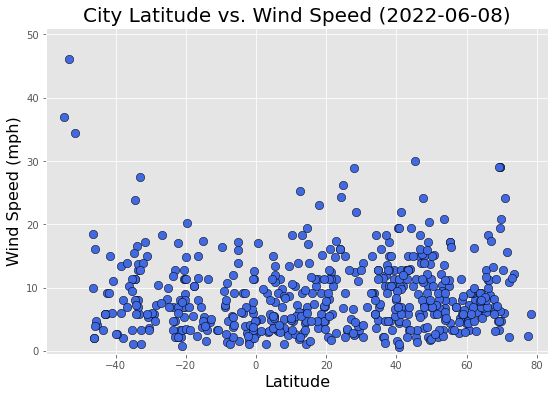

In [28]:
# Build a scatter plot for all cities vs wind speed:
plt.figure(figsize=(9,6))
plt.scatter(weather_data['Lat'], weather_data['Wind Speed'], marker='o', edgecolors='black', color='royalblue',  s=[70])

# Incorporate the other graph properties:
plt.title('City Latitude vs. Wind Speed ' + '(' + str(pd.datetime.now().date()) + ')', fontsize=20)
plt.ylabel('Wind Speed (mph)', fontsize=16, color='black')
plt.xlabel('Latitude', fontsize=16, color='black')

# Set the limits of the y axis:
plt.ylim(min(weather_data['Wind Speed'])-1, max(weather_data['Wind Speed'])+5)

# Set the limits of the x axis:
plt.xlim(min(weather_data['Lat'])-5, max(weather_data['Lat'])+5)

# Save the figure
plt.savefig('../output_data/City Latitude vs. Wind.png')

# Show plot
plt.show()

## Linear Regression

In [29]:
# Create new data frame for northern hemisphere (lat >= 0 degree):
weather_data_north = weather_data[weather_data['Lat'] >= 0]

#weather_data_north.count()

# Create new data frame for southern hemisphere (lat < 0 degree):
weather_data_south = weather_data[weather_data['Lat'] < 0]

#weather_data_south.count()

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

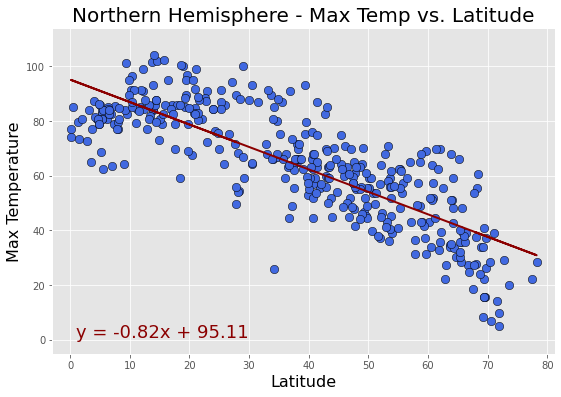

In [32]:
# Build scatter plot for each data type:
plt.figure(figsize=(9,6))
x_values = weather_data_north['Lat']
y_values = weather_data_north['Max Temp']

# Perform a linear regression for temperature vs. latitude:
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values:
regress_values = x_values * slope + intercept

# Create line equation string:
line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))

# Create plot:
plt.scatter(x_values,y_values, marker='o', color='royalblue', s=[70], edgecolors='black')
plt.plot(x_values,regress_values, 'darkred', linewidth=2)

# Incorporate the other graph properties:
plt.title('Northern Hemisphere - Max Temp vs. Latitude', fontsize=20)
plt.ylabel('Max Temperature', fontsize=16, color='black')
plt.xlabel('Latitude', fontsize=16, color='black')
plt.annotate(line_eq,(1, 1), fontsize=18, color='darkred')
#plt.grid(False)

# Set the limits of the y axis:
plt.ylim(min(weather_data['Max Temp'])-10, max(weather_data['Max Temp'])+10)

# Set the limits of the x axis:
plt.xlim(-3, max(weather_data['Lat'])+3)

# Print r-squared value:
#print(f'The r-squared is: {round(rvalue**2,2)}')

# Save the figure:
plt.savefig('../output_data/City Latitude vs. MaxTemp_North.png')

# Show plot:
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

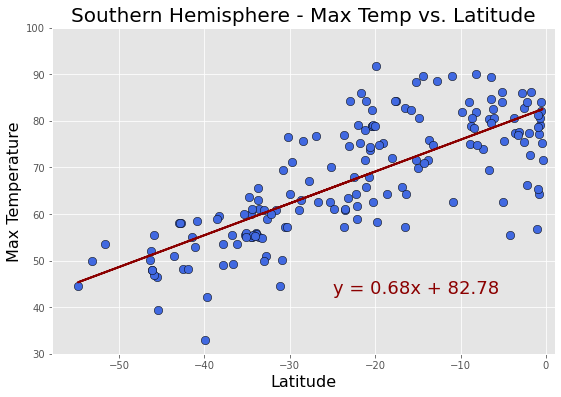

In [33]:
# Build scatter plot for each data type:
plt.figure(figsize=(9,6))
x_values = weather_data_south['Lat']
y_values = weather_data_south['Max Temp']

# Perform a linear regression for temperature vs. latitude:
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values:
regress_values = x_values * slope + intercept

# Create line equation string:
line_eq2 = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))

# Create plot:
plt.scatter(x_values,y_values, marker='o', color='royalblue', s=[70], edgecolors='black')
plt.plot(x_values,regress_values, 'darkred', linewidth=2)

# Incorporate the other graph properties:
plt.title('Southern Hemisphere - Max Temp vs. Latitude', fontsize=20)
plt.ylabel('Max Temperature', fontsize=16, color='black')
plt.xlabel('Latitude', fontsize=16, color='black')
plt.annotate(line_eq2,(-25,43),fontsize=18, color='darkred')
#plt.grid(False)

# Set the limits of the y axis:
plt.ylim(30, 100)

# Set the limits of the x axis:
plt.xlim(min(weather_data['Lat'])-3, +1)

# Print r-squared value:
#print(f'The r-squared is: {round(rvalue**2,2)}')

# Save the figure:
plt.savefig('../output_data/City Latitude vs. MaxTemp_South.png')

# Show plot:
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

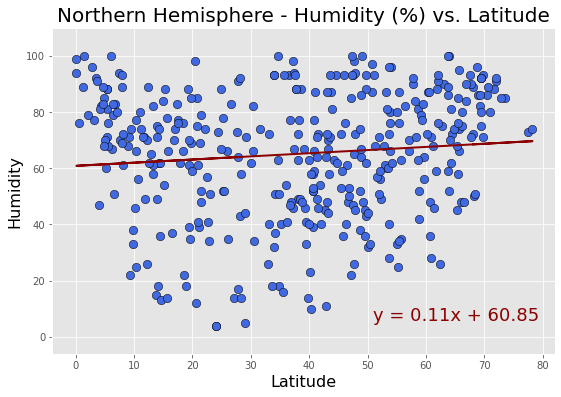

In [34]:
# Build scatter plot for each data type:
plt.figure(figsize=(9,6))
x_values = weather_data_north['Lat']
y_values = weather_data_north['Humidity']

# Perform a linear regression for humidity vs. latitude:
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values:
regress_values = x_values * slope + intercept

# Create line equation string:
line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))

# Create plot:
plt.scatter(x_values,y_values, marker='o', color='royalblue', s=[70], edgecolors='black')
plt.plot(x_values,regress_values,'darkred', linewidth=2)

# Incorporate the other graph properties:
plt.title('Northern Hemisphere - Humidity (%) vs. Latitude', fontsize=20)
plt.ylabel('Humidity', fontsize=16, color='black')
plt.xlabel('Latitude', fontsize=16, color='black')
plt.annotate(line_eq,(51,6),fontsize=18, color='darkred')
#plt.grid(False)

# Set the limits of the y axis:
plt.ylim(-6, 110)

# Set the limits of the x axis:
plt.xlim(-4, 82)

# Print r-squared value:
#print(f'The r-squared is: {round(rvalue**2,2)}')

# Save the figure:
plt.savefig('../output_data/City Latitude vs. Humidity_North.png')

# Show plot:
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

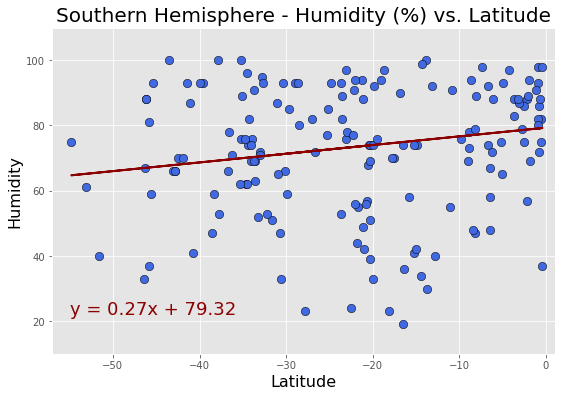

In [35]:
# Build scatter plot for each data type:
plt.figure(figsize=(9,6))
x_values = weather_data_south['Lat']
y_values = weather_data_south['Humidity']

# Perform a linear regression for humidity vs. latitude:
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values:
regress_values = x_values * slope + intercept

# Create line equation string:
line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))

# Create plot:
plt.scatter(x_values,y_values, marker='o', color='royalblue', s=[70], edgecolors='black')
plt.plot(x_values,regress_values,'darkred', linewidth=2)

# Incorporate the other graph properties:
plt.title('Southern Hemisphere - Humidity (%) vs. Latitude', fontsize=20)
plt.ylabel('Humidity', fontsize=16, color='black')
plt.xlabel('Latitude', fontsize=16, color='black')
plt.annotate(line_eq,(-55,22), fontsize=18, color='darkred')
#plt.grid(False)

# Set the limits of the y axis:
plt.ylim(10, 110)

# Set the limits of the x axis:
plt.xlim(-57, 1)

# Print r-squared value:
#print(f'The r-squared is: {round(rvalue**2,2)}')

# Save the figure:
plt.savefig('../output_data/City Latitude vs. Humidity_South.png')

# Show plot:
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

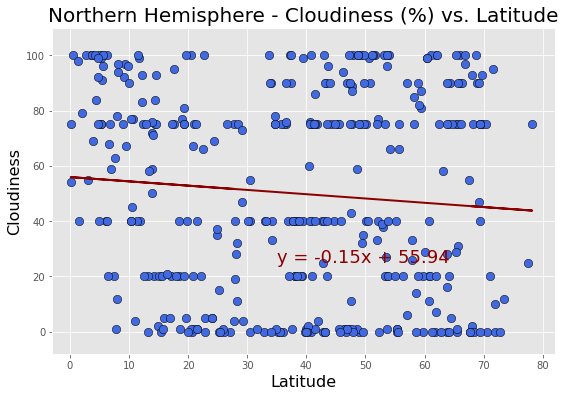

In [36]:
# Build scatter plot for each data type:
plt.figure(figsize=(9,6))
x_values = weather_data_north['Lat']
y_values = weather_data_north['Cloudiness']

# Perform a linear regression for cloudiness vs. latitude:
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values:
regress_values = x_values * slope + intercept

# Create line equation string:
line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))

# Create plot:
plt.scatter(x_values,y_values, marker='o', color='royalblue', s=[70], edgecolors='black')
plt.plot(x_values,regress_values,'darkred', linewidth=2)

# Incorporate the other graph properties:
plt.title('Northern Hemisphere - Cloudiness (%) vs. Latitude', fontsize=20)
plt.ylabel('Cloudiness', fontsize=16, color='black')
plt.xlabel('Latitude', fontsize=16, color='black')
plt.annotate(line_eq,(35,25), fontsize=18, color='darkred')
#plt.grid(False)

# Set the limits of the y axis:
plt.ylim(-8, 110)

# Set the limits of the x axis:
plt.xlim(-3, 82)

# Print r-squared value:
#print(f'The r-squared is: {round(rvalue**2,2)}')

# Save the figure:
plt.savefig('../output_data/City Latitude vs. Cloudiness_North.png')

# Show plot:
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

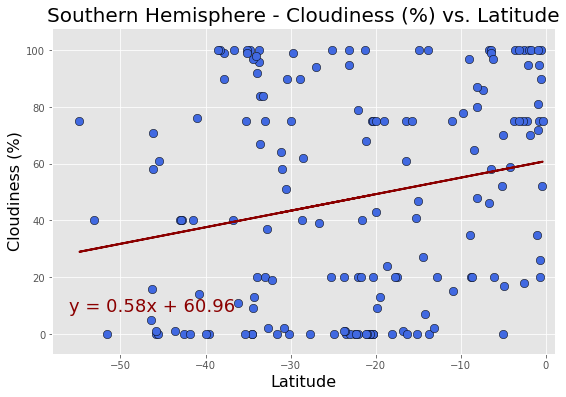

In [37]:
# build scatter plot for each data type:
plt.figure(figsize=(9,6))
x_values = weather_data_south['Lat']
y_values = weather_data_south['Cloudiness']

# Perform a linear regression for cloudiness vs. latitude:
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values:
regress_values = x_values * slope + intercept

# Create line equation string:
line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))

# Create plot:
plt.scatter(x_values,y_values, marker='o', color='royalblue', s=[70], edgecolors='black')
plt.plot(x_values,regress_values,'darkred', linewidth=2)

# Incorporate the other graph properties:
plt.title('Southern Hemisphere - Cloudiness (%) vs. Latitude', fontsize=20)
plt.ylabel('Cloudiness (%)', fontsize=16, color='black')
plt.xlabel('Latitude', fontsize=16, color='black')
plt.annotate(line_eq,(-56,8), fontsize=18, color='darkred')
#plt.grid(False)

# Set the limits of the y axis:
plt.ylim(-7, 108)

# Set the limits of the x axis:
plt.xlim(-58, 1)

# Print r-squared value:
#print(f'The r-squared is: {round(rvalue**2,2)}')

# Save the figure:
plt.savefig('../output_data/City Latitude vs. Cloudiness_South.png')

# Show plot:
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

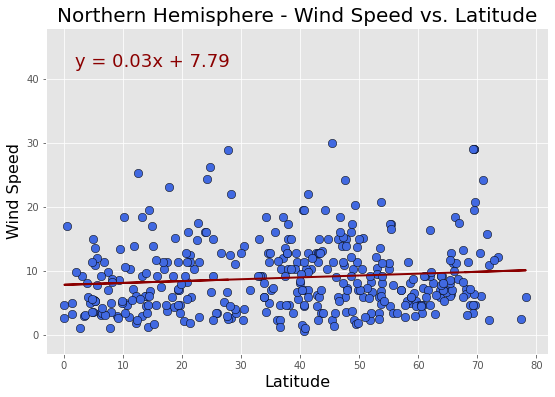

In [38]:
# Build scatter plot for each data type:
plt.figure(figsize=(9,6))
x_values = weather_data_north['Lat']
y_values = weather_data_north['Wind Speed']

# Perform a linear regression for wind speed vs. latitude:
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values:
regress_values = x_values * slope + intercept

# Create line equation string:
line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))

# Create plot:
plt.scatter(x_values,y_values, marker='o', color='royalblue', s=[70], edgecolors='black')
plt.plot(x_values,regress_values,'darkred', linewidth=2)

# Incorporate the other graph properties:
plt.title('Northern Hemisphere - Wind Speed vs. Latitude', fontsize=20)
plt.ylabel('Wind Speed', fontsize=16, color='black')
plt.xlabel('Latitude', fontsize=16, color='black')
plt.annotate(line_eq,(2,42), fontsize=18, color='darkred')
#plt.grid(False)

# Set the limits of the y axis:
plt.ylim(-3, 48)

# Set the limits of the x axis:
plt.xlim(-3, 82)

# Print r-squared value:
#print(f'The r-squared is: {round(rvalue**2,2)}')

# Save the figure:
plt.savefig('../output_data/City Latitude vs. Wind_North.png')

# Show plot:
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

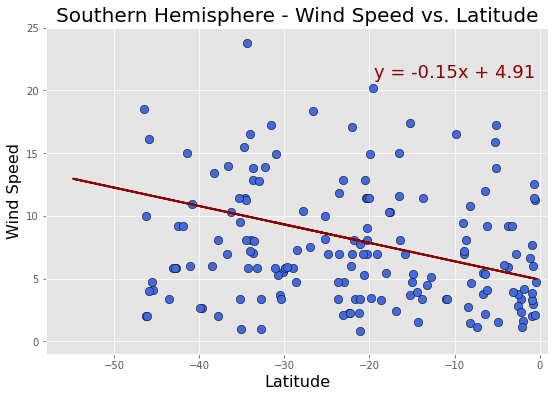

In [40]:
# Build scatter plot for each data type:
plt.figure(figsize=(9,6))
x_values = weather_data_south['Lat']
y_values = weather_data_south['Wind Speed']

# Perform a linear regression on wind speed vs. latitude:
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values:
regress_values = x_values * slope + intercept

# Create line equation string:
line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))

# Create plot:
plt.scatter(x_values,y_values, marker='o', color='royalblue', s=[70], edgecolors='black')
plt.plot(x_values,regress_values,'darkred', linewidth=2)

# Incorporate the other graph properties:
plt.title('Southern Hemisphere - Wind Speed vs. Latitude', fontsize=20)
plt.ylabel('Wind Speed', fontsize=16, color='black')
plt.xlabel('Latitude', fontsize=16, color='black')
plt.annotate(line_eq,(-19.5,21), fontsize=18, color='darkred')
#plt.grid(False)

# Set the limits of the y axis:
plt.ylim(-1, 25)

# Set the limits of the x axis:
plt.xlim(-58, 1)

# Print r-squared value:
#print(f'The r-squared is: {round(rvalue**2,2)}')

# Save the figure:
plt.savefig('../output_data/City Latitude vs. Wind_South.png')

# Show plot:
plt.show()